# ECE4179 Final Project
### Buy or Sell Stock Classifier

##### By Ridhwan Mohamed rmoh0004@student.monash.edu, Jeremy Vasic jvas9@student.monash.edu 

### NOTE: change C:\Users\Jeremy\Desktop\ECE4179 Project RidhwanM and JeremyV\  to your local file directory

In [29]:
#Install Libraries
#!pip install pytrends
#!pip install yfinance --upgrade --no-cache-dir
#!pip install pandas
#!pip install pytorch

## Fetching Google Trends data

Documentation for PyTrends request: https://pypi.org/project/pytrends/#historical-hourly-interest
<br />Getting started with PyTrends: https://yanwei-liu.medium.com/getting-the-google-trends-data-with-python-67b335e7d1cf

In [2]:
from pytrends.request import TrendReq
from pytrends import dailydata
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import time

# #Example to test if PyTrends is working
# pytrend = TrendReq(hl='en-US', tz=360)
# keywords = ['Python', 'TSLA']
# pytrend.build_payload(
#      kw_list=keywords,
#      cat=0,
#      timeframe='2018-01-01 2019-12-31',
#      geo='TW',
#      gprop='')
# data = pytrend.interest_over_time()
# data= data.drop(labels=['isPartial'],axis='columns') #Removing uncessary columns from dataframe
# image = data.plot(title = 'Python V.S. TSLA Google Trends ')
# fig = image.get_figure()
# fig.savefig('figure.png')
# data.to_csv('Py_VS_TSLA.csv', encoding='utf_8_sig')

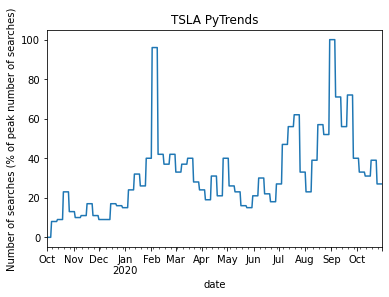

In [3]:
#Using the .get_daily_data as, the above PyTrends methods only get WEEKLY data for pull requests over 3 months
pyTrendsdata_full = dailydata.get_daily_data('TSLA', 2019, 10, 2020, 10, geo = 'US')
clear_output(True)
#print(pyTrendsdata_full,"\n")

pyTrendsdata = pyTrendsdata_full['TSLA_monthly'] #Selecting only the search requests data column
pyTrendsdata = pyTrendsdata.fillna(0) #Removing all NaN values 
#print(pyTrendsdata,"\n")
#print('pyTrendsdata Shape:', pyTrendsdata.shape,"\n")

image = pyTrendsdata.plot(title = 'TSLA PyTrends')
image.set_ylabel("Number of searches (% of peak number of searches)")
fig = image.get_figure()
fig.savefig('figure.png')
pyTrendsdata.to_csv('TSLA.csv', encoding='utf_8_sig')

## Fetching the Yahoo Finance data

<br />Documentation for yFinance requests: https://towardsdatascience.com/is-it-possible-to-predict-stock-prices-with-a-neural-network-d750af3de50b

In [4]:
import yfinance as yf
import numpy as np

stock = yf.Ticker('TSLA')
print(stock.recommendations)

history = stock.history(start="2019-10-01", end="2020-10-31", interval = '1d')
#print(history)
close = history['Close']
volume = history['Volume']
grade = stock.recommendations['To Grade']
#print(grade)

index = yf.Ticker('SPY')
history2 = index.history(start="2019-10-01", end="2020-10-31", interval = '1d')

history2.rename(columns={'Close': 'Index_Close'}, inplace=True)
index_close= history2['Index_Close']


#Getting previous weeks price history
close_tMinus1 = close.shift(1)
close_tMinus1.rename('Close_tMinus1', inplace=True)

close_tMinus2 = close.shift(2)
close_tMinus2.rename('Close_tMinus2', inplace=True)

close_tMinus3 = close.shift(3)
close_tMinus3.rename('Close_tMinus3', inplace=True)

close_tMinus4 = close.shift(4)
close_tMinus4.rename('Close_tMinus4', inplace=True)

close_tMinus5 = close.shift(5)
close_tMinus5.rename('Close_tMinus5', inplace=True)

close_tMinus6 = close.shift(6)
close_tMinus6.rename('Close_tMinus6', inplace=True)


#Combining pyTrends and yFinance data
combined = pd.merge(close_tMinus6, close_tMinus5, left_index=True, right_index=True)
combined = pd.merge(combined, close_tMinus4, left_index=True, right_index=True)
combined = pd.merge(combined, close_tMinus3, left_index=True, right_index=True)
combined = pd.merge(combined, close_tMinus2, left_index=True, right_index=True)
combined = pd.merge(combined, close_tMinus1, left_index=True, right_index=True)
combined = pd.merge(combined, close, left_index=True, right_index=True)

#combined = pd.merge(close, volume, left_index=True, right_index=True) 
combined = pd.merge(combined, volume, left_index=True, right_index=True)
combined = pd.merge(combined, index_close, left_index=True, right_index=True)
combined = pd.merge(combined, pyTrendsdata, left_index=True, right_index=True)  #this one
combined = pd.merge_asof(combined, grade, left_index=True,right_index=True)
#print(combined)

#Removing first week of data, as no previous close price data for it
combined = combined.drop(pd.date_range('2019-10-01', '2019-10-09'), errors='ignore')

#renaming col names
combined.rename(columns={'To Grade': 'Recent_Recommendation'}, inplace=True)


#Creating target labels -1 and 1, using change in Close price from previous day
combined['Delta'] = (combined['Close'] - combined['Close'].shift(1)).fillna(0) 
combined['Delta'] = combined['Delta'].shift(-1)
combined['Prediction'] = np.where(combined['Delta'] >0, 1, 0) #Prediction 1 = BUY, 0 = SELL
combined = combined.drop(labels=['Delta'],axis='columns')
print(combined)
combined.to_csv('OurData.csv', encoding='utf_8_sig', index = True)


                                  Firm           To Grade      From Grade  \
Date                                                                        
2012-02-16 07:42:00          JP Morgan         Overweight                   
2012-02-16 13:53:00         Wunderlich               Hold                   
2012-02-17 06:17:00         Oxen Group                Buy                   
2012-03-26 07:31:00         Wunderlich                Buy                   
2012-05-22 05:57:00        Maxim Group                Buy                   
...                                ...                ...             ...   
2020-10-22 10:22:18     JMP Securities  Market Outperform  Market Perform   
2020-10-22 10:24:21              Baird         Outperform         Neutral   
2020-10-22 13:41:29  Canaccord Genuity               Hold                   
2020-10-23 12:01:58     Morgan Stanley       Equal-Weight                   
2020-10-27 16:56:46          Citigroup               Sell                   

In [5]:
dataset = pd.read_csv(r'C:\Users\Jeremy\Desktop\ECE4179 Project RidhwanM and JeremyV\OurData.csv')
print("dataset shape:",dataset.shape)
dataset.head() #Displays first 5 entries

dataset shape: (267, 13)


,Unnamed: 0,Close_tMinus6,Close_tMinus5,Close_tMinus4,Close_tMinus3,Close_tMinus2,Close_tMinus1,Close,Volume,Index_Close,TSLA_monthly,Recent_Recommendation,Prediction
0,2019-10-10,48.625999,46.605999,46.285999,47.543999,48.009998,48.905998,48.948002,31416500,287.676880,8.0,Market Perform,1
1,2019-10-11,46.605999,46.285999,47.543999,48.009998,48.905998,48.948002,49.577999,42377000,290.659180,8.0,Market Perform,1
2,2019-10-14,46.285999,47.543999,48.009998,48.905998,48.948002,49.577999,51.391998,51025000,290.335480,9.0,Market Perform,1
3,2019-10-15,47.543999,48.009998,48.905998,48.948002,49.577999,51.391998,51.577999,32164000,293.209900,9.0,Market Perform,1
4,2019-10-16,48.009998,48.905998,48.948002,49.577999,51.391998,51.577999,51.950001,33420500,292.738983,9.0,Market Perform,1


Text(0, 0.5, 'Correct decision split')

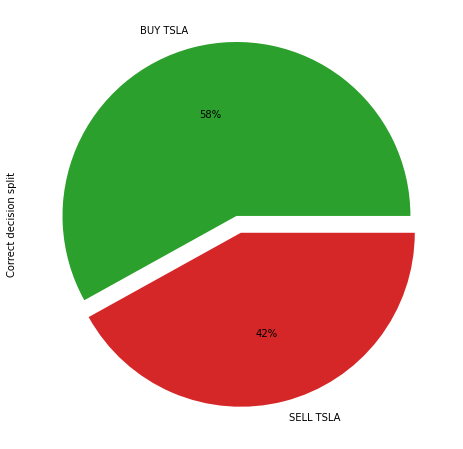

In [6]:
#Some cool graphs from the Stackabuse website
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
piechart = dataset.Prediction.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['tab:green', 'tab:red'], explode=(0.05, 0.05),labels=['BUY TSLA','SELL TSLA'])
piechart.set_ylabel("Correct decision split")


## Data Cleaning

Source of implementation: https://stackabuse.com/introduction-to-pytorch-for-classification/

In [7]:
#Showing the columns we are working with
dataset.columns

Index(['Unnamed: 0', 'Close_tMinus6', 'Close_tMinus5', 'Close_tMinus4',
       'Close_tMinus3', 'Close_tMinus2', 'Close_tMinus1', 'Close', 'Volume',
       'Index_Close', 'TSLA_monthly', 'Recent_Recommendation', 'Prediction'],
      dtype='object')

In [8]:
categorical_columns = ['Recent_Recommendation']
numerical_columns = ['Close_tMinus6','Close_tMinus5','Close_tMinus4','Close_tMinus3','Close_tMinus2','Close_tMinus1','Close', 'Volume', 'Index_Close', 'TSLA_monthly']
#numerical_columns = ['Close_tMinus6','Close_tMinus5','Close_tMinus4','Close_tMinus3','Close_tMinus2','Close_tMinus1','Close', 'Volume', 'Index_Close']
outputs = ['Predicted']

#Showing that object datatype exists, which wil causes errors
dataset.dtypes

Unnamed: 0                object
Close_tMinus6            float64
Close_tMinus5            float64
Close_tMinus4            float64
Close_tMinus3            float64
Close_tMinus2            float64
Close_tMinus1            float64
Close                    float64
Volume                     int64
Index_Close              float64
TSLA_monthly             float64
Recent_Recommendation     object
Prediction                 int64
dtype: object

In [9]:
for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')
    
#Showing that object datatype is now category datatype
dataset.dtypes

Unnamed: 0                 object
Close_tMinus6             float64
Close_tMinus5             float64
Close_tMinus4             float64
Close_tMinus3             float64
Close_tMinus2             float64
Close_tMinus1             float64
Close                     float64
Volume                      int64
Index_Close               float64
TSLA_monthly              float64
Recent_Recommendation    category
Prediction                  int64
dtype: object

In [10]:
dataset['Recent_Recommendation'].cat.categories

Index(['Buy', 'Equal-Weight', 'Hold', 'Market Outperform', 'Market Perform',
       'Neutral', 'Outperform', 'Overweight', 'Sell', 'Underperform',
       'Underweight'],
      dtype='object')

In [11]:
dataset['Recent_Recommendation'].head()

0    Market Perform
1    Market Perform
2    Market Perform
3    Market Perform
4    Market Perform
Name: Recent_Recommendation, dtype: category
Categories (11, object): [Buy, Equal-Weight, Hold, Market Outperform, ..., Overweight, Sell, Underperform, Underweight]

In [12]:
dataset['Recent_Recommendation'].head().cat.codes

0    4
1    4
2    4
3    4
4    4
dtype: int8

In [13]:
import torch
recc = dataset['Recent_Recommendation'].cat.codes.values

categorical_data = np.stack([recc], 1)

categorical_data[:10]

numerical_data = np.stack([dataset[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:5]

tensor([[4.8626e+01, 4.6606e+01, 4.6286e+01, 4.7544e+01, 4.8010e+01, 4.8906e+01,
         4.8948e+01, 3.1416e+07, 2.8768e+02, 8.0000e+00],
        [4.6606e+01, 4.6286e+01, 4.7544e+01, 4.8010e+01, 4.8906e+01, 4.8948e+01,
         4.9578e+01, 4.2377e+07, 2.9066e+02, 8.0000e+00],
        [4.6286e+01, 4.7544e+01, 4.8010e+01, 4.8906e+01, 4.8948e+01, 4.9578e+01,
         5.1392e+01, 5.1025e+07, 2.9034e+02, 9.0000e+00],
        [4.7544e+01, 4.8010e+01, 4.8906e+01, 4.8948e+01, 4.9578e+01, 5.1392e+01,
         5.1578e+01, 3.2164e+07, 2.9321e+02, 9.0000e+00],
        [4.8010e+01, 4.8906e+01, 4.8948e+01, 4.9578e+01, 5.1392e+01, 5.1578e+01,
         5.1950e+01, 3.3420e+07, 2.9274e+02, 9.0000e+00]])

In [14]:
outputs = ['Prediction']
outputs = torch.tensor(dataset[outputs].values).flatten()
outputs[:5]

tensor([1, 1, 1, 1, 1])

In [15]:
print('Shape of:')
print(categorical_data.shape)
print(numerical_data.shape)
print(outputs.shape)

Shape of:
(267, 1)
torch.Size([267, 10])
torch.Size([267])


In [16]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(11, 6)]


In [17]:
total_records = categorical_data.shape[0];
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

In [18]:
print('Length of:')
print('categorical_train_data',len(categorical_train_data))
print('numerical_train_data',len(numerical_train_data))
print('train_outputs',len(train_outputs))

print('categorical_test_data',len(categorical_test_data))
print('numerical_test_data',len(numerical_test_data))
print('test_outputs',len(test_outputs))

Length of:
categorical_train_data 214
numerical_train_data 214
train_outputs 214
categorical_test_data 53
numerical_test_data 53
test_outputs 53


## Defining the NN model

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [20]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200,100,50], p=0.4)
print(model)

#Hyperparameters
epochs = 500
lr = 0.001 #learning rate
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(11, 6)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [21]:
#Converting to PyTorch tensor
categorical_train_data = torch.tensor(categorical_train_data)
categorical_train_data = categorical_train_data.long() #for compatibility with functions below
categorical_test_data = torch.tensor(categorical_test_data)
categorical_test_data = categorical_test_data.long()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random

aggregated_losses = []

best_accuracy = 0
best_epoch = 0

testAccuracyLogger = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        clear_output(True)
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        print(best_accuracy)
        print(best_epoch)
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
    
    #####
    with torch.no_grad():
        y_val = model(categorical_test_data, numerical_test_data)
        loss = loss_function(y_val, test_outputs)
    y_val2 = np.argmax(y_val, axis=1)
    accuracy = accuracy_score(test_outputs, y_val2)
    testAccuracyLogger.append(accuracy)
    if (accuracy>best_accuracy):
        best_accuracy = accuracy
        best_epoch = i
    
    
clear_output(True)
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
print('Best accuracy: ',"%.3f" % (best_accuracy*100),'% at epoch ',best_epoch,sep='')
print('Final accuracy: ',"%.3f" % (accuracy_score(test_outputs, y_val2)*100),'%',sep='')

epoch: 500 loss: 0.5237179995
Best accuracy: 73.585% at epoch 280
Final accuracy: 56.604%


Text(0.5, 1.0, 'Training Loss per epoch')

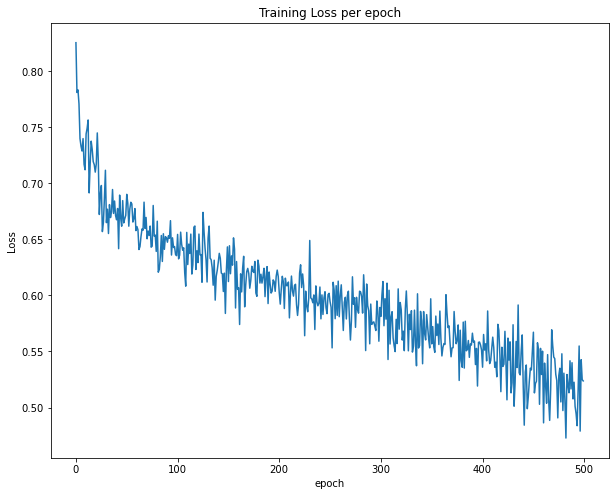

In [23]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');
plt.title("Training Loss per epoch")

Text(0.5, 1.0, 'Test Accuracy per epoch')

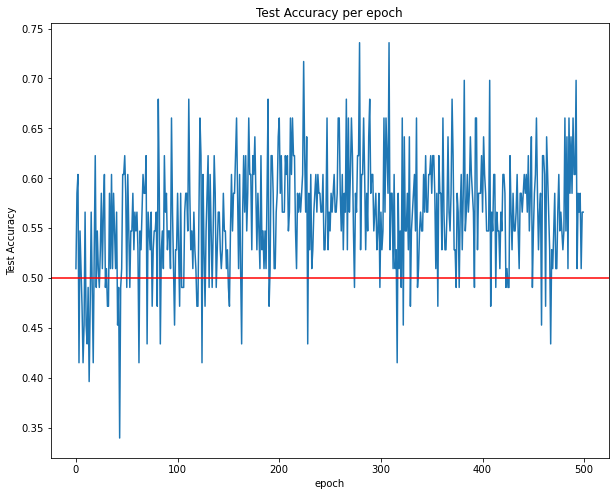

In [24]:
#Plotting test accuracy
plt.plot(range(epochs), testAccuracyLogger)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Test Accuracy')
plt.xlabel('epoch');
plt.title("Test Accuracy per epoch")

In [25]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')


Loss: 1.07325673


In [26]:
print('y_val shape:',y_val.shape)
print('test_outputs shape:',test_outputs.shape)
y_val2 = np.argmax(y_val, axis=1)
print('First y_val measurment:',y_val[:1])
print('First 5 y_val2 measurments:',y_val2[:5])

y_val shape: torch.Size([53, 2])
test_outputs shape: torch.Size([53])
First y_val measurment: tensor([[0.2308, 0.1786]])
First 5 y_val2 measurments: tensor([0, 1, 1, 0, 0])


In [27]:
#The method of displaying the confusion matrix was adapted from an online article
#Source code: https://medium.com/swlh/image-classification-tutorials-in-pytorch-transfer-learning-19ebc329e200
from sklearn import metrics

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize,
                          title=None,
                          cmap=plt.cm.Greens): 
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
# Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    #Option to normalize data for comparing data with differen ranges, this was not used in the report
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > (thresh*1.5) else "black")
    fig.tight_layout()
    return ax

[[ 7 15]
 [15 16]]
              precision    recall  f1-score   support

           0       0.32      0.32      0.32        22
           1       0.52      0.52      0.52        31

    accuracy                           0.43        53
   macro avg       0.42      0.42      0.42        53
weighted avg       0.43      0.43      0.43        53

0.4339622641509434
Confusion matrix, without normalization
[[ 7 15]
 [15 16]]


<Figure size 720x576 with 0 Axes>

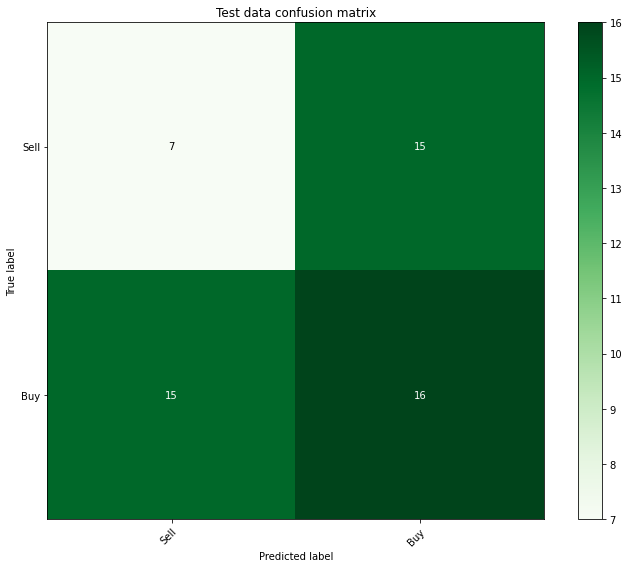

In [28]:
print(confusion_matrix(test_outputs,y_val2))
print(classification_report(test_outputs,y_val2))
print(accuracy_score(test_outputs, y_val2))
plt.figure()
classes = np.array(["Sell","Buy"]) 
plot_confusion_matrix(test_outputs, y_val2, classes = classes,normalize=False,title='Test data confusion matrix')